## Project 2 Predict NZX 50 index with energy consumption, export and tourists

### <center>Yonggang Li (18043158)</center>

### Abstract
It is well known for market economy countries that stock market is a barometer of the economy and the economic growth and the potential will be reacted by the stock market. The NZX 50 Index, which comprises the 50 biggest stocks in New Zealand, is to some extent reflects the economy of the country. In this project, oil and electricity consumption, exports, and tourists are selected as the indicators of the economy. Their relationships with NZX 50 index are researched and find that the oil consumption, exports and the number of tourists show positive correlation with the index. Simple linear regression and k-nearest neighbour (kNN) regression models are built to predict NZX 50 index from tourists. 

### Introduction 
The data used in this paper are from,<br> 
* <a href="http://www.mbie.govt.nz/info-services/sectors-industries/energy/energy-data-modelling/statistics/documents-image-library/oil.xlsx">Oil consumption</a> 
* <a href="http://www.mbie.govt.nz/info-services/sectors-industries/energy/energy-data-modelling/statistics/documents-image-library/electricity.xlsx">Electricity consumption</a> 
* <a href="http://archive.stats.govt.nz/infoshare/default.aspx">Export</a> select "Imports and exports" --> "Exports - Summary Data - EXP" --> "Total Exports ($billions) (Monthly)"
* <a href="http://archive.stats.govt.nz/infoshare/default.aspx">Tourism</a>  select "Tourism" --> "International Travel and Migration - ITM" --> "Total passenger movements", only select Arrivals.
* <a href="https://nz.finance.yahoo.com/quote/%5ENZ50/history?period1=1041332400&period2=1533038400&interval=1mo&filter=history&frequency=1mo">NZX 50 index</a> 
<br>

As it is hard to collect daily economy data and to reduce the volatility of stock market, the quarterly records from 2002 Q4 till 2018 Q1 are collected or aggregated. The following topics are addressed,
* Explore the trend of all the features
* Visualise pair-wise relationships and correlation between all the features
* Split data into two parts for training and testing models
* Build different order of polynomial modles and a multi-linear regression model
* Build kNN models with different k value and weights
* Test all the models with testing data set, RMSE for each model is calculated
* Discussing of applying the best model

### Import necessary data analysis libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pylab import rcParams
rcParams['figure.dpi'] = 350
rcParams['lines.linewidth'] = 2
rcParams['axes.facecolor'] = 'white'
rcParams['patch.edgecolor'] = 'white'
rcParams['font.family'] = 'StixGeneral'
rcParams['figure.figsize'] = 12,9
rcParams['font.size'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

sns.set(style="ticks")

%matplotlib inline

pd.set_option('html', True)

#### Import libraries for grabing data via HTTP request and response

In [3]:
import requests as req      
import json
from bs4 import BeautifulSoup as bs

### Read data
#### Read NZX 50 from https://nz.finance.yahoo.com/quote/%5ENZ50?p=^NZ50 and parse
As one reqest for the page could not retrieve all records since December 31st 2002, sending two requests for from 2010-06-01 to 2018-08-01 and 2002-12-31 to 2010-05-31, then merge these two parts into one. Reading March, June, September, and December as only the quarterly close data is needed. Assign an unified id for each quarter, for example 2004Q3, 2018Q1.<br><br>
<b>Notes</b>:<br>
* Ignore the second value if a month appears two times, e.g. for 01 Sep. 2007 and 3 Sep. 2007, just keep 01 Sep.2007 as the Q3 close
* If a month is missing, use the close of the predecessor month as it's close, e.g. use the close of 1 April 2003 as the close of March 2003 


In [4]:
from dateutil import parser
def load_quaterly_nzx50(url): 
    response = req.get(url)
    nzx50 = bs(response.content, "lxml")
    nzx50 = nzx50.find("table", attrs = {'data-test' : 'historical-prices'})
    trList = nzx50.find(name='tbody').findAll(name='tr')
    
    ids = []
    adjClose = []
    lastMonth = 0
    for tr in trList:
        tds = tr.findAll(name='td')
        dt = parser.parse(tds[0].text)
        if lastMonth == dt.month:
            continue
        elif dt.month in [3, 6, 9, 12]:
            label = str(dt.year)+"Q"+str(dt.month/3)
            ids.append(label)
            adjClose.append(float(tds[5].text.replace(',','')))
        elif dt.month in [2, 5, 8] and lastMonth in [4, 7, 10]:
            label = str(dt.year)+"Q"+str((lastMonth-1)/3)
            ids.append(label)
            adjClose.append(float(tds[5].text.replace(',','')))
            
        lastMonth = dt.month
    nzx50 = pd.DataFrame({'NZX50':adjClose}, index=ids)
    return nzx50

print 'Loading NZX 50 historical data...'
nzx50_part1 = load_quaterly_nzx50("https://nz.finance.yahoo.com/quote/%5ENZ50/history?period1=1275307200&period2=1533038400&interval=1mo&filter=history&frequency=1mo")
nzx50_part2 = load_quaterly_nzx50("https://nz.finance.yahoo.com/quote/%5ENZ50/history?period1=1038654000&period2=1275220800&interval=1mo&filter=history&frequency=1mo")
nzx50 = pd.concat([nzx50_part1, nzx50_part2])
nzx50 = nzx50.reindex(index=nzx50.index[::-1])
nzx50.drop(nzx50[nzx50.index == '2018Q2'].index, inplace=True)
print "Done"

Loading NZX 50 historical data...
Done


In [7]:
def plot_line_chart(data, xlabel, ylabel, title):
    data.plot(figsize=(8, 4))
    plt.xticks(rotation=15, fontsize=12)
    plt.title(title, fontsize=16, alpha=0.5)
    plt.xlabel(xlabel, fontsize=14, alpha=0.5)
    plt.ylabel(ylabel, fontsize=14, alpha=0.5)
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='both',alpha=0.4)

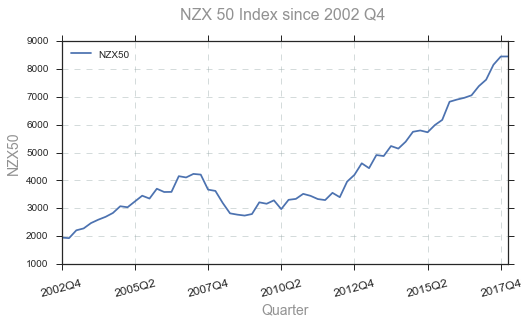

In [6]:
plot_line_chart(nzx50, 'Quarter', 'NZX50', 'NZX 50 Index since 2002 Q4 \n')

#### Load the other pre-collected data from local file
The quarterly consumption of oil and electricity, arrivals of total passengers from the first quarter of 2001 to the first of 2008 and monthly export data are stored in oil_electricity-exports-tourism.xlsx. But they have different format and export data needs to be aggregated. 
* Load data from sheet 'oil-electricity', 'exports', and 'tourism'
* Set index of all data sets with unified quarter fromat, e.g. 2002Q4
* Choose records of 2002Q4 to 2018Q1
<br><br>
* <b>Load oil and electricity</b>

In [9]:
energy = pd.read_excel('oil-electricity-exports-tourism.xlsx', sheetname='oil-electricity')
energy = energy.transpose()
# unify the index format
ids = []
for dt in energy.index:
    ids.append(str(dt.year)+'Q'+str(dt.month/3))
eHeader = "Electricity (GWh)"
energy[eHeader] = energy[[eHeader]].apply(np.round, axis=1)
energy.index = ids

# drop data records before 2002Q4 to align with NZX 50
indexToDrop = energy[energy.index < '2002Q4']
energy.drop(indexToDrop.index, inplace=True)

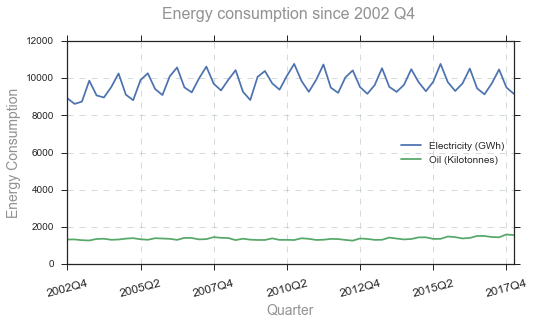

In [11]:
plot_line_chart(energy, 'Quarter', 'Energy Consumption', 'Energy consumption since 2002 Q4 \n')

* <b>Load exports data</b>

In [10]:
exports = pd.read_excel('oil-electricity-exports-tourism.xlsx', sheetname='exports')
# drop data before October 2002
exports.drop(exports[exports.Month < '2002M10'].index, inplace=True)
# parse the date and set the index for grouping
exports.index = pd.to_datetime(exports['Month'], format='%YM%m')
exports.index.name = None
# drop 'Month' as it is no use now
exports.drop('Month', axis=1, inplace=True)
# group the data by quarter
exports = exports.groupby(pd.PeriodIndex(exports.index, freq='Q')).sum()
exports.index = energy.index

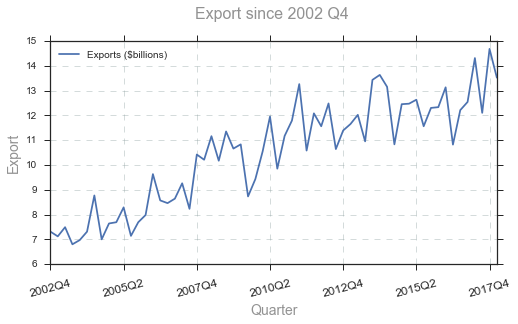

In [14]:
plot_line_chart(exports, 'Quarter', 'Export', 'Export since 2002 Q4 \n')

* <b>Load tourists data

In [11]:
tourists = pd.read_excel('oil-electricity-exports-tourism.xlsx', sheetname='tourism')
tourists.drop(tourists[tourists.Quarter < '2002Q4'].index, inplace=True)
tourists = tourists.set_index('Quarter')
tourists.index.name = None

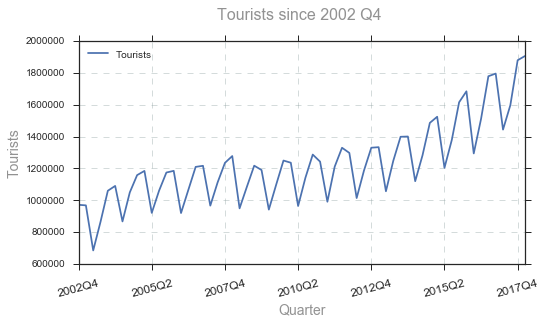

In [16]:
plot_line_chart(tourists, 'Quarter', 'Tourists', 'Tourists since 2002 Q4 \n')

The consumption of oil and electricity keeps steadily and there is no significant increase except seasonal fluctuation. The exports and tourists shows a similar trend as stock market and we will do a further check.

* <b>Now, all data sets from 2002 Q4 to 2018 Q1 are ready, merge them into one DataFrame and show the first 5 rows.

In [13]:
economics = pd.merge(tourists, exports, left_index=True, right_index=True)
economics = pd.merge(economics, energy, left_index=True, right_index=True)
economics = pd.merge(economics, nzx50, left_index=True, right_index=True)
# let's make the column name shorter and simpler
economics = economics.rename(columns={'Exports ($billions)': 'Exports', 'Electricity (GWh)': 'Electricity', 'Oil (Kilotonnes)': 'Oil'})
economics.head()

,Tourists,Exports,Electricity,Oil,NZX50
2002Q4,972107,7.31,8919,1325.86,1953.22
2003Q1,968688,7.12,8614,1328.04,1931.61
2003Q2,685999,7.49,8741,1287.17,2212.52
2003Q3,865744,6.80,9864,1271.52,2280.83
2003Q4,1060358,6.97,9071,1352.79,2471.51


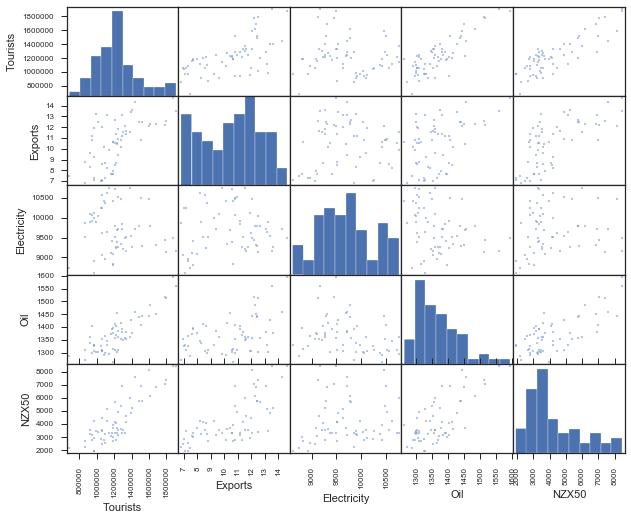

In [18]:
_ = pd.tools.plotting.scatter_matrix(economics, diagonal = 'hist',figsize=(10,8))

In [19]:
economics.corr()

,Tourists,Exports,Electricity,Oil,NZX50
Tourists,1.000000,0.625958,-0.085323,0.840852,0.847159
Exports,0.625958,1.000000,0.083743,0.456777,0.693894
Electricity,-0.085323,0.083743,1.000000,-0.284323,0.124669
Oil,0.840852,0.456777,-0.284323,1.000000,0.740477
NZX50,0.847159,0.693894,0.124669,0.740477,1.000000


Both the scatter matrix and correlations show that there are positive relationships and in particular between the NZX 50 index as a predictor while Tourists and Oil consumption as response variables. <br/>

### Split the data into training and testing data sets
Now, we are almost ready to build models but before doing that let's split the data set into two parts, 80% of the data for training the model and the other 20% for testing. 

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn import neighbors
from sklearn import linear_model
from sklearn import cross_validation as cv

In [22]:
train_df, test_df = cv.train_test_split(economics, test_size=0.2, random_state=0)
train_df.shape, test_df.shape

((49, 5), (13, 5))

Define some utility functions for plot a linear regression model and calculate R-squared and RMSE for evaluate the goodness of fit

In [27]:
def plot_linear_regression_model(X, Y, lrModel, polyN, color):
    x = pd.DataFrame({'Tourists': np.linspace(X.min(), X.max(), len(X))})
    plt.scatter(X, Y, s=20, alpha=0.6)
    plt.xlabel('Tourists') 
    plt.ylabel('NZX50')
    #display the regression line
    plt.plot(x.Tourists, lrModel.predict(x), color, label=polyN+' $R^2$=%.2f' % lrModel.rsquared, alpha=0.9)
    plt.legend(loc='upper left', framealpha=0.5, prop={'size':'medium'})
    plt.title("Predicting NZX 50 Index With Tourists--Training\n", fontsize=16)
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='both',alpha=0.4)
    
def calculate_rmse(y, y_hat):
    residual= np.sum(np.square(np.subtract(y, y_hat)))
    return np.sqrt( residual / float(len(y)) )

def calculate_r_squared(y, y_hat):
    y_mean = y.mean()
    ss_total = np.sum(np.square(np.subtract(y, y_mean)))
    ss_regression = np.sum(np.square(np.subtract(y_hat, y_mean)))
    return (ss_regression / ss_total)

### Linear regression model
#### Build linear model and check the goodness of fit
Let's first build a linear regression model with NZX 50 index and tourists as they show the strongest relationship.

In [24]:
lrModel = smf.ols(formula='NZX50 ~ 1 + Tourists', data=train_df).fit()
lrModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  NZX50   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     120.0
Date:                Sun, 02 Sep 2018   Prob (F-statistic):           1.56e-14
Time:                        22:57:31   Log-Likelihood:                -404.69
No. Observations:                  49   AIC:                             813.4
Df Residuals:                      47   BIC:                             817.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept  -2926.6522    681.296     -4.296      0.000     -4297.243 -1556.062
Tourists       0.0058      0.001     10.954      0.000         0.005     0.007
==============================================================================
Omnibus:                        3.503   Durbin-Watson:                   2.542
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                3.345
Skew:                           0.614   Prob(JB):                        0.188
Kurtosis:                       2.640   Cond. No.                     6.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

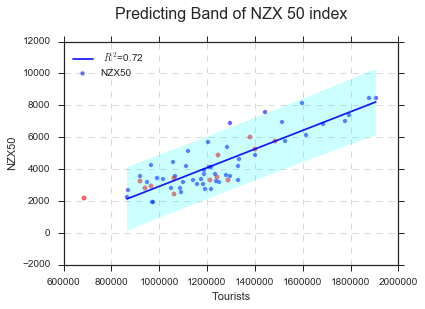

In [47]:
plot_linear_regression_model(train_df.Tourists, train_df.NZX50, lrModel,  "", 'b-')
plt.title("Predicting Band of NZX 50 index\n", fontsize=16)
#extract the parameters for the confidence window
x_pred = np.linspace(train_df.Tourists.min(), train_df.Tourists.max(), len(train_df.Tourists))
x_pred2 = sm.add_constant(x_pred)
#confidence = 95% (alpha=0.05)
sdev, lower, upper = wls_prediction_std(lrModel, exog=x_pred2, alpha=0.05)
#display the testing data
plt.scatter(test_df.Tourists, test_df.NZX50, color='red', s=20, alpha=0.6)
#plot points and confidence window
_ = plt.fill_between(x_pred, lower, upper, color='Aqua', alpha=0.2)

As the 95% prediection band indicates that 95% of all the data point should fall into the band, here for training data set, 41 over 43 are in the band. For testing data, 12/13 is in the band, which is lower than 95%.

#### Let's try two polynomial models 
<div> $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$</div> and <div> $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \beta_3 x_i^3 + \epsilon_i$</div>

In [25]:
# 2-nd order polynomial
poly_2 = smf.ols(formula='NZX50 ~ 1 + Tourists + I(Tourists ** 2.0)', data=train_df).fit()

# 3-rd order polynomial
poly_3 = smf.ols(formula='NZX50 ~ 1 + Tourists + I(Tourists ** 2.0) + I(Tourists ** 3.0)', data=train_df).fit()

#### Plot the training and testing data with the Models and R-Squared

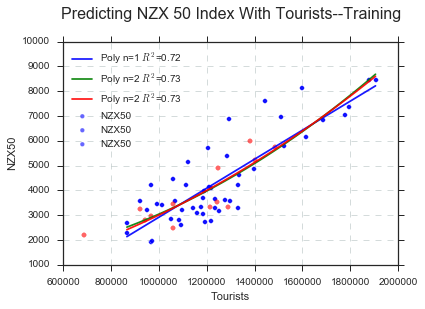

In [42]:
plot_linear_regression_model(train_df.Tourists, train_df.NZX50, lrModel,  "Poly n=1", 'b-')
plot_linear_regression_model(train_df.Tourists, train_df.NZX50, poly_2, "Poly n=2", 'g-')
plot_linear_regression_model(train_df.Tourists, train_df.NZX50, poly_3, "Poly n=2", 'r-')
_ = plt.scatter(test_df.Tourists, test_df.NZX50, color='red',s=20, alpha=0.6)

#### Try a multi-linear model

From the correlation matrix, oil consumption and exports show a weaker but positive relationship with NZX 50 index. Let's check if a multiple linear model can enhance the performance of prediction. 

In [32]:
multi_linear = smf.ols(formula='NZX50 ~ 1 + Tourists + Oil + Exports', data=train_df).fit()
print 'R-Squared: ', multi_linear.rsquared

R-Squared:  0.78538930258


It seems that multi-linear model works better as the R-squared increased about 8% because more features are included.

### kNN model
Now, try kNN model with neighbors.KNeighborsRegressor from sklearn. 

In [29]:
X = train_df.Tourists.values
y = train_df.NZX50.values
count = len(train_df.NZX50)
X = np.reshape(X, (count, 1))
y = np.reshape(y, (count, 1))
# build model on different number of neighbors, here 2, 5, 8 will be used
k_neighbors = [2, 8, 32]
d_models = []
u_models = []
for k in k_neighbors:
    knn = neighbors.KNeighborsRegressor(k, weights='distance')
    d_models.append(knn.fit(X, y))
    knn = neighbors.KNeighborsRegressor(k, weights='uniform')
    u_models.append(knn.fit(X, y))

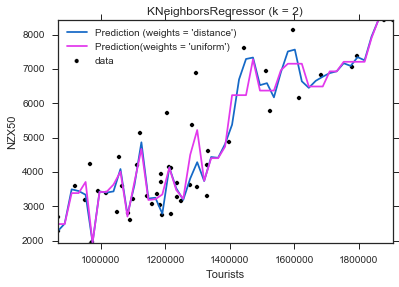

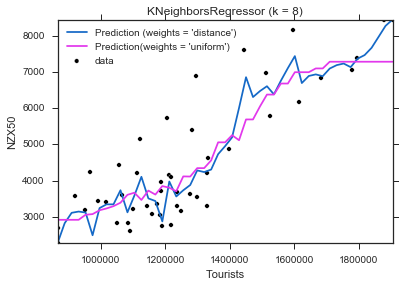

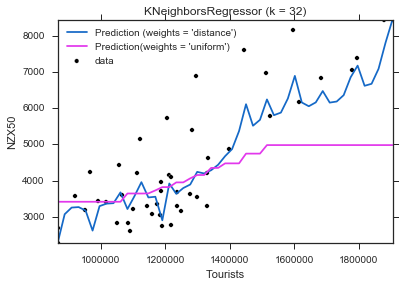

In [30]:
x = np.linspace(X.min(), X.max(), count)[:, np.newaxis]
plt_index = 0
for i in range(3):
    y_hat_d = d_models[i].predict(x)
    plt.plot(x, y_hat_d, c='#1569C7', label="Prediction (weights = 'distance')")
    y_hat_u = u_models[i].predict(x)
    plt.plot(x, y_hat_u, c='#E238EC', label="Prediction(weights = 'uniform')")

    plt.axis('tight')
    plt.scatter(X, y, c='k', label='data')
    plt.xlabel('Tourists')
    plt.ylabel('NZX50')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i)" % (k_neighbors[i]))
    plt.show()

As the figures show that when K gets bigger, the curves are smoother for both weights but the difference between 'distance' and 'uniform' weights become more and more obvious. Let's check the RMSE for all these models on testing data.

In [33]:
count = len(test_df.NZX50)
x = np.reshape(test_df.Tourists.values, (count, 1))
y = np.reshape(test_df.NZX50.values, (count, 1))
rmse = []
models = []
for i in range(3):
    y_hat = d_models[i].predict(x)
    rmse.append(calculate_rmse(y, y_hat))
    models.append("kNN-%i, 'dis'" % k_neighbors[i])
    y_hat = u_models[i].predict(x)
    rmse.append(calculate_rmse(y, y_hat))
    models.append("kNN-%i, 'uni'" % k_neighbors[i])

test_x = pd.DataFrame({'Tourists': test_df.Tourists})
regs = [lrModel, poly_2, poly_3]
for m in regs:
    rmse.append(calculate_rmse(y, m.predict(test_x)))
rmse.append(calculate_rmse(y, multi_linear.predict(test_df)))

models = models + ['Poly 1', 'Poly 2', 'Poly 3', 'Multi linear']
rmse = pd.DataFrame({'Model': models, 'RMSE':rmse})
rmse = rmse.sort_values('RMSE').reset_index()

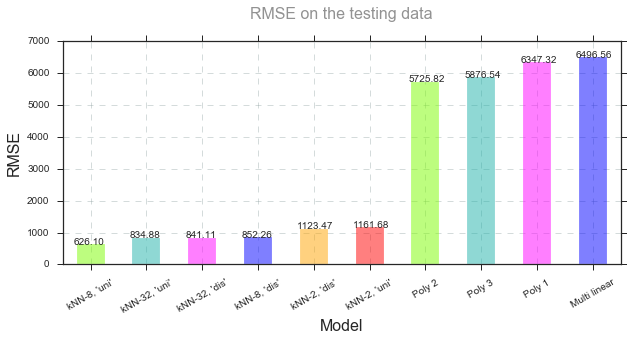

In [34]:
colors = ['#7CFC00','#20B2AA','#FF00FF','b','orange','red','#7CFC00','#20B2AA','#FF00FF','b']
ax = rmse.plot(kind='bar', x='Model', y='RMSE', color=colors, alpha=0.5, rot=30, legend=False, figsize=(10,4))
plt.title("RMSE on the testing data\n", fontsize=16, alpha=0.5)
plt.ylabel('RMSE', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='both',alpha=0.4)
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 -0.3, b.y1))

The bar chart about RMSE clearly shows that kNN models outperforms simple linear regression models against the testing data, RMSE from the polynomial models is generally nine times of the value from kNN models.<br>
Among the six kNN models, the model build on K=8 and weight='uniform' has the best prediction ability.<br>
As to the polynomial models, they perform closely to each other despite increasing the complexity. Among them <div> $y_i = \beta_0 + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$</div> shows the best performance. Multi-linear model gives a better R-Squared, 0.78 > 0.73, but also gives the biggest RMSE, which increased 29% compared with second polynomial model.

### Is it profitable to invest NZX 50 by predicting it with tourists
New Zealand is becoming more and more popular in the world tourism market and therefore the tourists are expected to increase, can it be used to predict the stock market and further take the prediction as investment basis? First, the model is built on historical data and the future might completely different. Second, don't forget the factors outside the model! New Zealand stock market is small and is vulnerable to the world economic situation, for example, the growing trade war might cause the people to lower down their income expectation and consequently reduce travel.

### Conclusion
Among energy consumption, exports and tourists, tourists show the strongest positive relationship with NZX 50 index. kNN model with k=8 and weights='uniform' beats all other models on RMSE. Multi-linear model won't help in this case.